In [10]:
%matplotlib inline

In [2]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

In [3]:
sys.path.append('/data/id13/inhouse12/jiliang/code_v3/xs_proc')
from visual_func import *
from xs_data_proc import *
from proc_data_ana import *

In [4]:
waxs_param_fn = '/data/id13/inhouse12/jiliang/code_v3/example/ihsc1654/hum_sample/qphi_parameter/waxs_qphi.npz'
angle = np.load(waxs_param_fn)['a']
qw = np.load(waxs_param_fn)['q']

In [15]:
def load_data_format(*kw,exclude=None,
    path='/data/id13/inhouse12/jiliang/code_v3/example/ihsc1654/hum_sample/HT_fiber1'):
    
    for _ in kw:
        path = os.path.join(path,f'*{_}*')
    print(path)
    data_list = []
    if not isinstance(exclude,type(None)):
        data_list1 = sorted(glob.glob(path))
        for _ in data_list1:
            if exclude not in _:
                data_list.append(_)
    else:
        data_list = sorted(glob.glob(path))
    return data_list

def load_qphi_edf(sn_list):
    sn_dict = {}
    for _ in sn_list:
        sn_dict[_.split('/')[-2]] = fabio.open(_).data
    return sn_dict



from lmfit import Model
amod = Model(azi_distr)
amod.set_param_hint('am',value=1,min=0)
amod.set_param_hint('mu',value=-10,min=-180,max=180)
amod.set_param_hint('sigma',value=10,min=1,max=90)
amod.set_param_hint('bkgd',value=0.1,min=0)
params = amod.make_params()
res   = amod.fit(Ia[np.isnan(Ia)==0],params,a=angle[np.isnan(Ia)==0])
mu    = res.params['mu'].value
sigma = res.params['sigma'].value

In [6]:
def amax_intensity_profile(qphi,angle,qw,azi_max,da=2,sym_corr=True):
    q,Ia = sum_roi(qphi,angle,qw,amin=azi_max-da,amax=azi_max+da,vs_axis='q')
    if sym_corr:
        if azi_max < 0:
            q,Ia1 = sum_roi(qphi,angle,qw,amin=azi_max+180-da,amax=azi_max+180+da,vs_axis='q') 
        else:
            q,Ia1 = sum_roi(qphi,angle,qw,amin=azi_max-180-da,amax=azi_max-180+da,vs_axis='q')
        return q,np.nanmean(np.vstack((Ia,Ia1)),axis=0)
    else:
        return q,Ia
#q,I = amax_intensity_profile(qphi,angle,qw,mu)
#plt.subplots()
#plt.semilogy(q,I)

In [16]:
hum_sample = {}

In [37]:
from lmfit import Model
def azi_fit_diff_hum(angle,qw,*kw,qmin=1.46,qmax=1.53,path=None):
    if isinstance(path,type(None)):
        qphi_file_list=load_data_format(*kw)
    else:
        qphi_file_list=load_data_format(*kw,path=path)
    qphi_dict = load_qphi_edf(qphi_file_list)

    amod = Model(azi_distr)

    mu_list    = []
    sigma_list = []
    Iq_e_list  = []
    Iq_m_list  = []
    Ia_list    = []
    roll_list  = []
    for _ in qphi_dict.keys():
        qphi = qphi_dict[_]
        qphi[qphi==0] = np.nan
        a,Ia = sum_roi(qphi,angle,qw,qmin=qmin,qmax=qmax,vs_axis='a')
        amod.set_param_hint('am',value=1,min=0)
        amod.set_param_hint('mu',value=angle[np.nanargmax(Ia)],min=-180,max=180)
        amod.set_param_hint('sigma',value=10,min=1,max=90)
        amod.set_param_hint('bkgd',value=0.1,min=0)
        params = amod.make_params()
        res   = amod.fit(Ia[np.isnan(Ia)==0],params,a=angle[np.isnan(Ia)==0])
        mu    = res.params['mu'].value
        sigma = res.params['sigma'].value
        mu_list.append(mu)
        sigma_list.append(sigma)
        if mu >= 0:
            roll_list.append(np.argmin(np.abs(angle-mu)-np.argmin(np.abs(angle-90))))
        else:
            roll_list.append(np.argmin(np.abs(angle-mu)-np.argmin(np.abs(angle+90))))
        q,I = amax_intensity_profile(qphi,angle,qw,mu)
        Iq_e_list.append(I)
        if mu > 90:
            q1,I1 = amax_intensity_profile(qphi,angle,qw,mu-90)
            Iq_m_list.append(I1)
        else:
            q1,I1 = amax_intensity_profile(qphi,angle,qw,mu+90)
            Iq_m_list.append(I1)
        Ia_list.append(Ia)
    return mu_list,sigma_list,Iq_e_list,Iq_m_list,Ia_list,roll_list
hum_rate = 'hum30'
mu_list,sigma_list,Iq_e_list,Iq_m_list,Ia_list,roll_list = azi_fit_diff_hum(angle,qw,hum_rate,'fiber1_qphi')

/data/id13/inhouse12/jiliang/code_v3/example/ihsc1654/hum_sample/HT_fiber1/*hum30*/*fiber1_qphi*


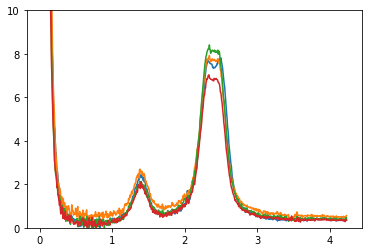

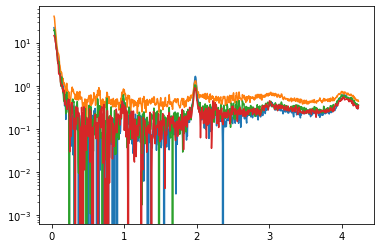

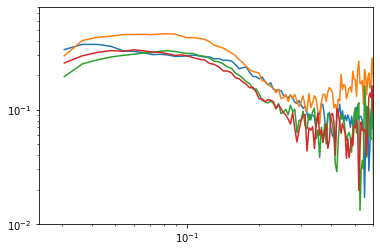

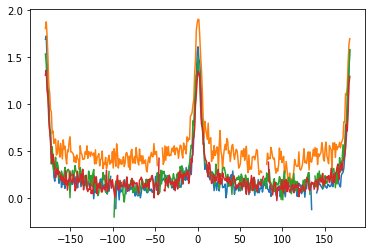

In [38]:
hum_sample_data = {}
plt.subplots()
for _ in Iq_e_list:
    plt.plot(qw,_)
hum_sample_data['Iq_e'] = Iq_e_list
plt.ylim(0,10)
plt.subplots()
for _ in Iq_m_list:
    plt.semilogy(qw,_)
hum_sample_data['Iq_m'] = Iq_m_list
plt.subplots()
for _ in Iq_e_list:
    plt.loglog(qw,_*qw**2)
plt.ylim(0.01,0.8)
plt.xlim(0,0.6)
    
plt.subplots()
Ia_list_new = np.copy(Ia_list)
for _,__ in enumerate(roll_list):
    plt.plot(angle,np.roll(Ia_list[_],-__))
    Ia_list_new[_,:] = np.roll(Ia_list[_],-__)
hum_sample_data['azi_distr'] = Ia_list_new
hum_sample[hum_rate] = hum_sample_data

In [39]:
hum_sample.keys()

dict_keys(['hum80', 'hum50', 'hum30'])

(0.01, 2)

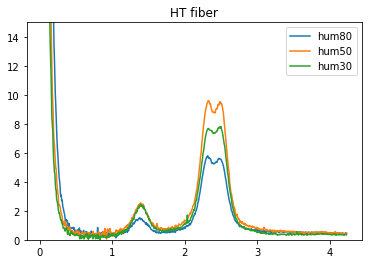

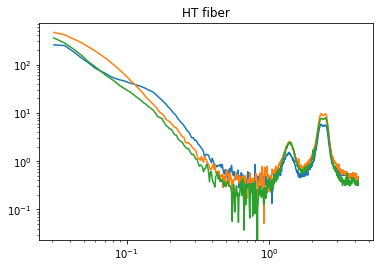

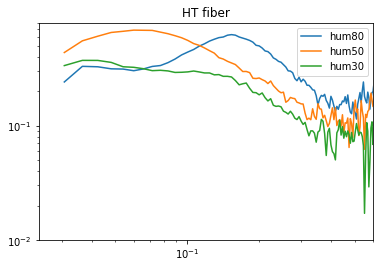

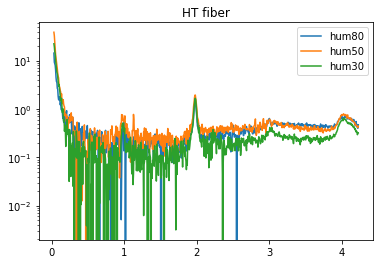

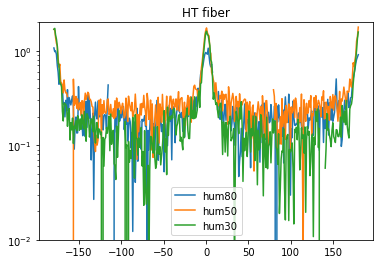

In [40]:
sample_keys = ['hum80','hum50','hum30']
sample_data_keys = ['Iq_e','Iq_m','azi_distr']
plt.subplots()
for i in sample_keys:
    Ie = hum_sample[i][sample_data_keys[0]][0]
    plt.plot(qw,Ie,label=f'{i}')
plt.ylim(0,15)
plt.legend()
plt.title('HT fiber')
plt.subplots()
for i in sample_keys:
    Ie = hum_sample[i][sample_data_keys[0]][0]
    plt.loglog(qw,Ie,label=f'{i}')
plt.title('HT fiber')
plt.subplots()
for i in sample_keys:
    Ie = hum_sample[i][sample_data_keys[0]][0]
    plt.loglog(qw,Ie*qw**2,label=f'{i}')
plt.legend()
plt.xlim(0,0.6)
plt.ylim(0.01,0.8)
plt.title('HT fiber')

plt.subplots()
for i in sample_keys:
    Im = hum_sample[i][sample_data_keys[1]][0]
    plt.semilogy(qw,Im,label=f'{i}')
plt.legend()
plt.title('HT fiber')
plt.subplots()
for i in sample_keys:
    Ia = hum_sample[i][sample_data_keys[2]][0]
    plt.semilogy(angle,Ia,label=f'{i}')
plt.legend()
plt.title('HT fiber')
plt.ylim(0.01,2)

In [56]:
mu_list,sigma_list,Iq_e_list,Iq_m_list,Ia_list,roll_list = \
    azi_fit_diff_hum(angle,qw,
                    'qphi',
                    path='/data/id13/inhouse12/jiliang/code_v3/example/ihsc1654/hum_sample/HT_fiber1/HT_fiber1_hum30_00min/60min_pos')

/data/id13/inhouse12/jiliang/code_v3/example/ihsc1654/hum_sample/HT_fiber1/HT_fiber1_hum30_00min/60min_pos/*qphi*


<IPython.core.display.Javascript object>


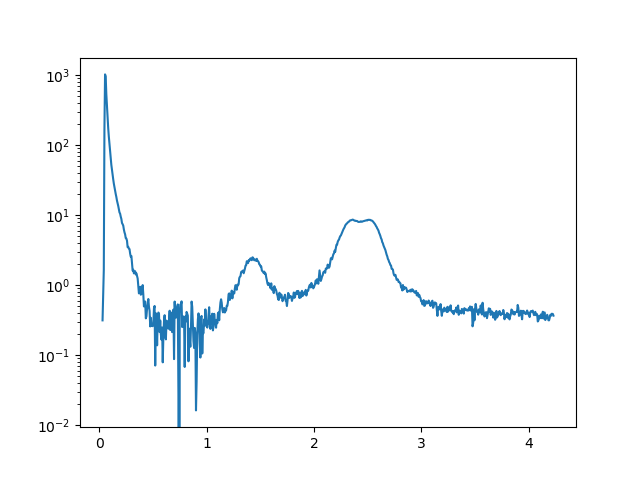

<IPython.core.display.Javascript object>


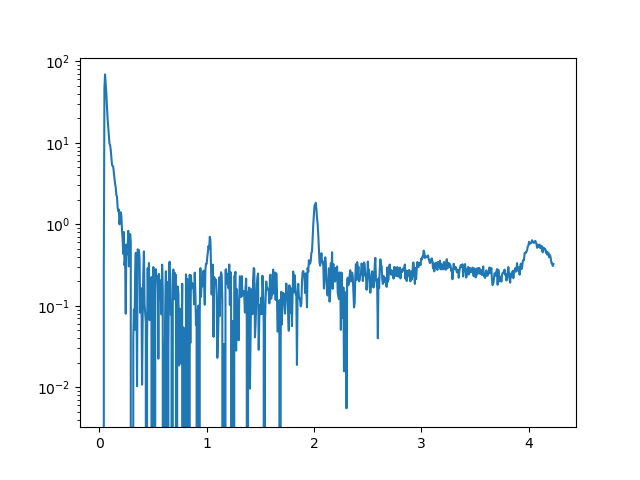

<IPython.core.display.Javascript object>


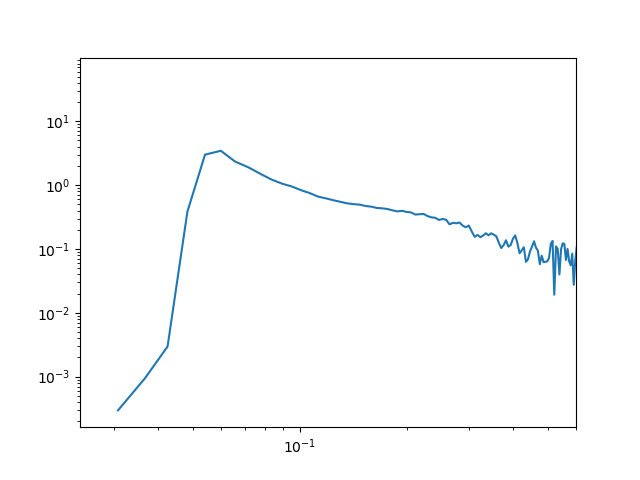

<IPython.core.display.Javascript object>


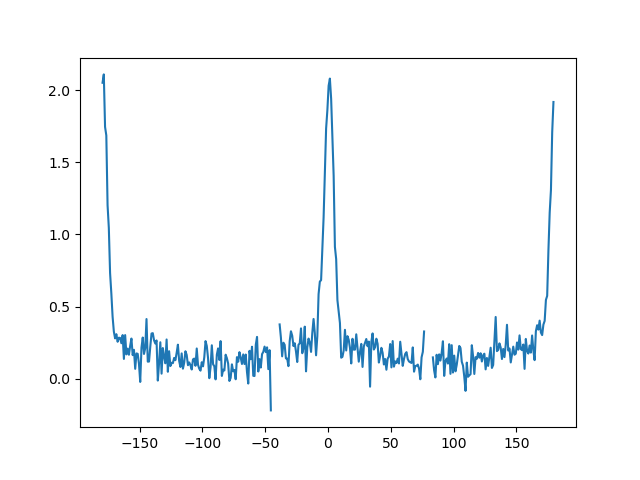

In [57]:
plt.subplots()
for _ in Iq_e_list:
    plt.semilogy(qw,_)
plt.subplots()
for _ in Iq_m_list:
    plt.semilogy(qw,_)

plt.subplots()
for _ in Iq_e_list:
    plt.loglog(qw,_*qw**2)
#plt.ylim(0.01,2)
plt.xlim(0,0.6)
    
plt.subplots()
for _,__ in enumerate(roll_list):
    plt.plot(angle,np.roll(Ia_list[_],-__))

In [75]:
?? sum_roi

In [76]:
q

array([0.03079646])